# Robust Facility Location

The Facility Location Problem (FLP) is a fundamental optimization challenge focusing on determining the optimal locations for facilities such as warehouses, plants, or distribution centers to minimize costs or maximize service coverage. It involves deciding where to place these facilities to efficiently serve demands from customers or locations, considering factors like transportation costs, facility setup costs, and capacity constraints. The goal of the facility location problem is to find the best allocation that satisfies demands and maxinimize profits.

In this notebook we will solve the example taken from Bertsimas and Den Hertog (2015) [1], Section 2.4. 

Let $ T, F, N \in \mathbb{N}$ be the length of the horizon, the number of candidate locations to which a facility can be assigned, and the number of locations that have a demand for the facility respectively. Let $\eta \in \mathbb{R}_+ $ be the unit price of goods. Let $c_{i}, C_{i} ,K_{i} \in \mathbb{R}_+ $ be the unit cost of production, cost of capacity and the cost of opening a location at facility $i$ respectively. Let $d_{ij} \in \mathbb{R}_+ $ be the cost of shipping from location $i$ to location $j$. Let $D_{j\tau} $ be the demand for period $\tau$ at location $j$. Decision variable $x_{ij\tau}$ represents the proportion of the demand at location $j$ during period $\tau$ that is satisfied by facility $i$. $P_{i\tau}$ represents the amount of good that is produced at facility $i$ during the period $\tau$. For each facility $i$, the decision variable $I_i$ denotes whether the facility in location $i $ is open or closed, by taking values 1 or 0, respectively, and $Z_i$ denotes the capacity of the facility in this location in case it is open. $M$ is a large constant.


With this information in mind, our optimization problem becomes:
$$
\begin{aligned}
& \text{maximize} \quad (\eta \cdot 1^T - d) \cdot (x \cdot D) -  c^T (1^TP) - C^TZ - K^T{I} \\
& \text{subject to} \quad 1^T x \leq 1,\\
&  x^T D \leq P, \\
& x \geq 0,  \\
&  P \leq Z, \\
&  Z \leq M I
\end{aligned}
$$

Lets look at each term of the objective function:

- The expression $ (\eta \cdot 1^T - d) \cdot (x \cdot D) $ represents the revenue generated from satisfying demand at location  $i$, time period $ \tau $, and serving demand from location $ j$. It calculates the difference between the revenue $ \eta $ and the unit demand $ d $, multiplied by the decision variable $x $ and the nominal demand $ D $.

- The expression $c^T (1^TP) $ represents the total production cost incurred at facility $ i $ across all time periods $ \tau $. It accounts for the production cost $ c $ associated with producing $ P$ units at facility $ i $.

- The expression $ C^TZ $ represents the fixed costs associated with opening facility $ i $, where $ C$ denotes the fixed cost and $ Z $ represents the binary decision variable indicating whether facility $ i $ is open $( Z_i = 1 )$ or closed $(Z_i = 0)$.

- Finally, $ K^T{I}$ represents the penalty or cost incurred if facility $ i $ remains open but does not operate efficiently. Here, $ K $ represents the penalty cost associated with inefficiency at facility $ i $, and $ I $ is a binary variable indicating whether facility $ i $ operates inefficiently $( I_i = 1 )$ or efficiently $( I_i = 0 )$.

In the robust version of this problem, we assume that the demand $d$ is uncertain. The parameter belongs to the Ellipsoidal Uncertainty set, which can be defined as: 

$$ \mathcal{U}_{\text{ellips}} = \{Az+b \ | \ \| z\|_2 \le \rho\} $$

- $A$ : np.array, optional
  * Scaling matrix for u. Default identity matrix.
- $b$ : np.array, optional
  * Relocation vector for u. Default None.

  
In this notebook, we define an uncertain parameter $D$ using the Ellipsoidal definition with $\rho=0.3, \mathbf{b}$ as value of $D$ in the deterministic case.

To solve this, we will first import the required packages. 

In [46]:
import numpy as np 
import cvxpy as cp 
import lropt
import networkx as nx
import matplotlib.pyplot as plt
import warnings

from scipy.sparse import SparseEfficiencyWarning
warnings.filterwarnings('ignore', category=UserWarning, module='cvxpy')
warnings.filterwarnings('ignore', category=SparseEfficiencyWarning)

Next, we will generate the data. We will consider an example where we have $5$ facilities and $8$ candidate locations. The length of each horizon is $10$. Finally, the unit price of each good is $100$.

In [47]:
np.random.seed(1)
T = 10  # Length of the horizon
F = 5   # Number of facilities
N = 8  # Number of candidate locations
M = 1100
NUM_DEC = 3

ETA = 100.0 
RHO = 0.3

c = np.random.rand(F)
C = np.random.rand(F)
K = np.random.rand(F)
d = np.random.rand(F, N)
D_value = np.random.rand(N* T)  # Deterministic demand

D = lropt.UncertainParameter(N*T, uncertainty_set = lropt.Ellipsoidal(b = D_value, rho = RHO))

x = cp.Variable((F*T,N), nonneg = True)  
P = cp.Variable((F, T), nonneg=True) 
P_T = P.T    
Z = cp.Variable(F)         
I = cp.Variable(F)        
epsilon = np.random.rand(T)
theta = cp.Variable()


Next, we we can define all our constraints

In [48]:
f1 = np.tile(ETA - d, (T, 1)).flatten()
revenue = cp.sum(cp.reshape(cp.multiply((f1), x.flatten()), (F,N*T)) @ D)
cost_production = cp.sum(c @ P)
fixed_costs = cp.sum(cp.multiply(C, Z))
penalties = cp.sum(cp.multiply(K, I))
x_reshaped = cp.reshape(x, (F, N*T))


constraints = [
revenue - cost_production - fixed_costs - penalties >= theta,
cp.sum(x.flatten()) <= 1,
x.flatten()>=0,
Z <= M*I,
cp.sum(x_reshaped @ D) <=cp.sum(P)
]

for t in range(T):
    constraints.append(P_T[t]<=Z)

Finally, we can define the objective and get the optimal value for the equation. 

In [49]:
objective = cp.Maximize(theta)
prob = lropt.RobustProblem(objective, constraints)
prob.solve()

In [50]:
print(f"The robust optimal value using  is {round(float(theta.value), NUM_DEC)}")

The robust optimal value using  is 85.583


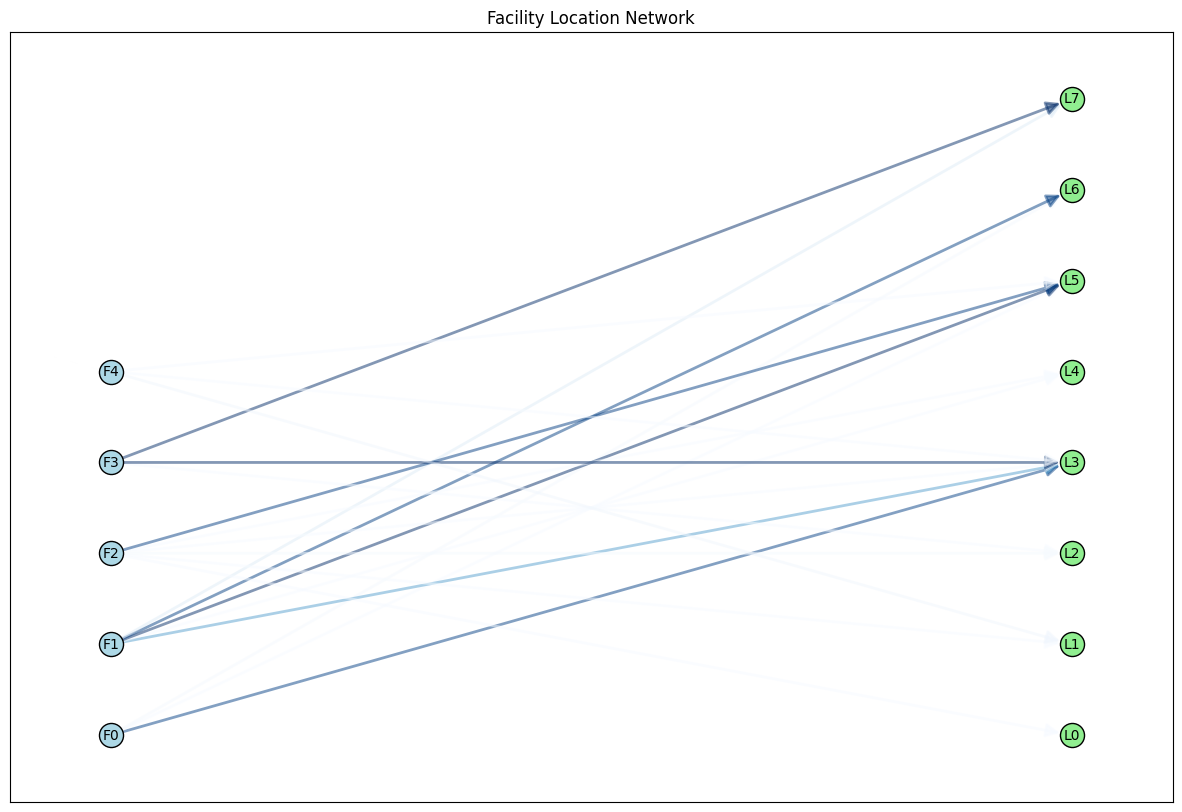

In [51]:
G = nx.DiGraph()

facility_nodes = range(F)
location_nodes = range(F, F + N)
G.add_nodes_from(facility_nodes, bipartite=0)
G.add_nodes_from(location_nodes, bipartite=1)


for i in range(F):
    for j in range(N):
        if x[i * T, j].value > 0:
            G.add_edge(i, F + j, weight=x[i * T, j].value)


pos = {}
for i in range(F):
    pos[i] = (0, i)
for j in range(N):
    pos[F + j] = (1, j)


fig, ax = plt.subplots(figsize=(15, 10))


nx.draw_networkx_nodes(G, pos, nodelist=facility_nodes, node_color='lightblue', node_size=300, edgecolors='k')
nx.draw_networkx_nodes(G, pos, nodelist=location_nodes, node_color='lightgreen', node_size=300, edgecolors='k')


edges = G.edges(data=True)
edge_weights = [data['weight'] for u, v, data in edges]


edge_weights = np.array(edge_weights)
edge_colors = edge_weights 


nx.draw_networkx_edges(G, pos, edgelist=edges, width=2, alpha=0.5, edge_color=edge_colors, edge_cmap=plt.cm.Blues, arrowsize=20)


nx.draw_networkx_labels(G, pos, labels={i: f"F{i}" for i in facility_nodes}, font_size=10, verticalalignment='center')
nx.draw_networkx_labels(G, pos, labels={F + j: f"L{j}" for j in range(N)}, font_size=10, verticalalignment='center')

plt.title('Facility Location Network')
plt.show()

# References

1. Bertsimas, Dimitris, and Dick Den Hertog. Robust and Adaptive Optimization. [Dynamic Ideas LLC], 2022.